<a href="https://colab.research.google.com/github/deeptijhade/Deepti_Jhade_SRISHTI_Assignments/blob/main/SRISHTI'23_Tutorial_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SRISHTI'23 - Tutorial 04**
### Features and Data Visualisation

---

# Feature Normalization

## Imputation of Missing Values 
There can be situations when there are some readings missing in our data. This creates outliers and brings in ambiguity. We cannot just fill in random values as that would result n wrong entries and the model might start behaving weitrdly to accomodate these features. There are various ways in which we can deal with this problem.

1. **Ignoring the Entries**: The simplest methosd is to ignore the entries which have missing values for some features. This way we will not have any ambiguity or wrong entry but our dataset will become smaller.
2. **Imputation Using (Mean/Median) Values:**: The missing values can be put as a mean or median of all the other values. This will give us features which the model can easily learn and won't affect the overall performance of our machine learning model. 
3. **Imputation Using (Most Frequent) or (Zero/Constant) Values:** It works with categorical features (strings or numerical representations) by replacing missing data with the most frequent values within each column. However this can create a bias in the model if there are too many missing values. 
4. **Imputation Using k-NN**: This method is very useful as it relies on feature similarity to assign the missing feature. We can perform a KNN and make the missing feature as the label. The semantically closest label based on the bneighbourhood will be assigned to the missing value. This method is much more accurate as compared to the other methods. 
5. **Imputation using Neural Networks** : We can use feature encoders and other neural networks to fill in the missing values as well. This method is computationally expnsive but the most effecient out of the methods that we have discussed. 

## Why is feature normalization required? 
Sometimes the features of our data have vastly different scales. This will cause the learning algorithm to give more importance to certain features, reducing its performance. Data normalization is a method in which we transform the features so that they have similar scales. 

Some commonly used feature scaling techniques are Min-Max scaling, clipping, log Normalization and z-score normalization. 

## Min-Max Scaling 
First, we will talk about the simplest one: rescaling or Min-Max Scaling. 

$$\begin{equation}
x' = \frac {x -min(x)} { max(x) - min(x)}
\end{equation}$$



For more information, see [this page](https://towardsdatascience.com/data-normalization-in-machine-learning-395fdec69d02).

In [4]:
import numpy as np
import pandas as pd
import math
from scipy.spatial import distance
import matplotlib.pyplot as plt

In [5]:
def rescale(data):
  return (data - data.min())/(data.max() - data.min())

We have to apply the rescaling to each feature individually. Also remember to apply the same transform we are using on the train set to the test set. Let's try to apply transformations on the MNIST dataset.

In [6]:
from keras.datasets import mnist
import matplotlib.pyplot as plt

In [7]:
#@title Helper Functions for plotting data
def plotData(X, y, xlabel = 'hole', ylabel = 'bound', fig=None, ax = None):

  if fig is None:
    fig, ax = plt.subplots()
  for ii in range(nclasses):
    plt.scatter(X[y==ii,0], X[y==ii, 1])
  plt.legend([str(i) for i in range(nclasses)])
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  lim2 = X.max() 
  lim1 = X.min() 
  add = abs(lim1-lim2)/5
  return fig, ax


In [8]:
## Code for 1 Nearest Neighbours. 

def NN1(traindata, trainlabel, query):
  diff  = traindata - query  # find the difference between features. Numpy automatically takes care of the size here 
  sq = diff*diff # square the differences
  dist = sq.sum(1) # add up the squares
  label = trainlabel[np.argmin(dist)] # our predicted label is the label of the training data which has the least distance from the query
  return label

def NN(traindata, trainlabel, testdata):
  # we will run nearest neighbour for each sample in the test data 
  # and collect the predicted classes in an array using list comprehension
  predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
  return predlabel

def Accuracy(gtlabel, predlabel):
  assert len(gtlabel)==len(predlabel), "Length of the groundtruth labels and predicted labels should be the same"
  correct = (gtlabel==predlabel).sum() # count the number of times the groundtruth label is equal to the predicted label.
  return correct/len(gtlabel)

def cumArray(img):
  img2 = img.copy()
  for ii in range(1, img2.shape[1]):
    img2[ii,:] = img2[ii,:] + img2[ii-1,:]  # for every row, add up all the rows above it.
  img2 = img2>0
  return img2

def getHolePixels(img):
  im1 = cumArray(img)
  im2 = np.rot90(cumArray(np.rot90(img)), 3) # rotate and cumulate it again for differnt direction
  im3 = np.rot90(cumArray(np.rot90(img, 2)), 2)
  im4 = np.rot90(cumArray(np.rot90(img, 3)), 1)
  hull =  im1 & im2 & im3 & im4 # this will create a binary image with all the holes filled in.
  hole = hull & ~ (img>0) # remove the original digit to leave behind the holes
  return hole

def getHullPixels(img):
  im1 = cumArray(img)
  im2 = np.rot90(cumArray(np.rot90(img)), 3) # rotate and cumulate it again for differnt direction
  im3 = np.rot90(cumArray(np.rot90(img, 2)), 2)
  im4 = np.rot90(cumArray(np.rot90(img, 3)), 1)
  hull =  im1 & im2 & im3 & im4 # this will create a binary image with all the holes filled in.
  return hull

def minus(a, b):
  return a & ~ b

def getBoundaryPixels(img):
  img = img.copy()>0  # binarize the image
  rshift = np.roll(img, 1, 1)
  lshift = np.roll(img, -1 ,1)
  ushift = np.roll(img, -1, 0)
  dshift = np.roll(img, 1, 0)
  boundary = minus(img, rshift) | minus(img, lshift) | minus(img, ushift) | minus(img, dshift)
  return boundary



In [9]:
#loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X/255
test_X = test_X/255

nclasses = 4

# get only for the first 4 classes
train_X = train_X[train_y<nclasses]
train_y = train_y[train_y<nclasses]
test_X = test_X[test_y<nclasses]
test_y = test_y[test_y<nclasses]

train_X = train_X[::100].copy() # We are only taking a subset of the training set
train_y = train_y[::100].copy() # do the same to the labels
test_X = test_X[::100].copy() # taking a subset of the test set. This code takes every 500th sample
test_y = test_y[::100].copy()

# get all the features
train_hole = np.array([getHolePixels(i).sum() for i in train_X])
test_hole = np.array([getHolePixels(i).sum() for i in test_X])
train_bound = np.array([getBoundaryPixels(i).sum() for i in train_X])
test_bound = np.array([getBoundaryPixels(i).sum() for i in test_X])
# train_hull = np.array([getHullPixels(i).sum() for i in train_X])
# test_hull = np.array([getHullPixels(i).sum() for i in test_X])
# train_sum = np.sum(train_X, (1,2))/(28*28)
# test_sum = np.sum(test_X, (1,2))/(28*28)

# create the train and test set by combining the appropriate features
train_feats = np.vstack((train_hole,train_bound)).transpose()
test_feats = np.vstack((test_hole, test_bound)).transpose()

11490434/11490434 [==============================] - 1s 0us/step


Text(0.5, 1.0, 'Data before scalng')

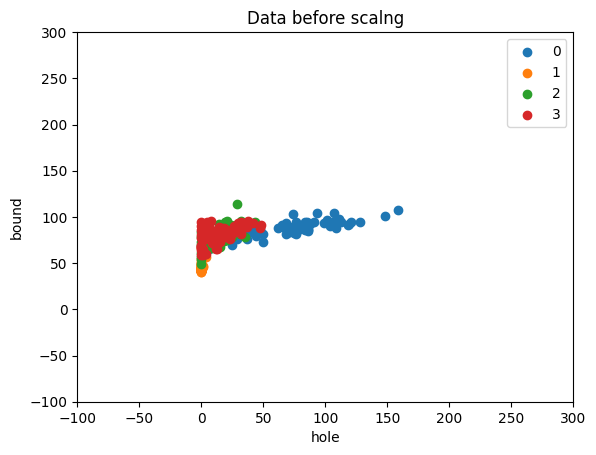

In [10]:
xlim=[-100,300]
ylim=[-100,300]
fig, ax = plotData(train_feats, train_y)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title("Data before scalng")

In [11]:
test_pred = NN(train_feats, train_y, test_feats)
acc = Accuracy(test_y, test_pred)
print('Baseline accuracy = ', acc)

Baseline accuracy =  0.7619047619047619


In [12]:
train_feats_rescaled_x = rescale(train_feats[:,0])
train_feats_rescaled_y = rescale(train_feats[:,1])
train_feats_rescaled = np.stack((train_feats_rescaled_x, train_feats_rescaled_y),1)

test_feats_rescaled_x = rescale(test_feats[:,0])
test_feats_rescaled_y = rescale(test_feats[:,1])
test_feats_rescaled = np.stack((test_feats_rescaled_x, test_feats_rescaled_y),1)

Text(0.5, 1.0, 'Data after scalng')

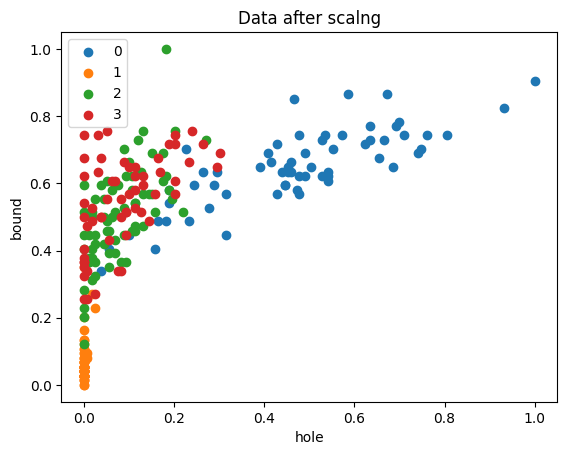

In [13]:
fig, ax = plotData(train_feats_rescaled, train_y)
ax.set_title("Data after scalng")

In [14]:
test_pred = NN(train_feats_rescaled, train_y, test_feats_rescaled)
acc = Accuracy(test_y, test_pred)
print('Accuracy after transform = ', acc)

Accuracy after transform =  0.8095238095238095


## Z-Score Clipping


Standardization or z-score normalization is one such scaling technique that transforms your data such that the resulting distribution has a mean of 0 and a standard deviation of 1. 

$$ \text{New (scaled) value} = {X - \mu \over \sigma}$$ 

In [15]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.33, random_state = 17)

In [18]:
#For 7 neighbours
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 7)
knn.fit(X_train,y_train)
scores = knn.score(X_test,y_test)
print("Score after Z clipping", scores)

Score after Z clipping 0.9521276595744681


In [19]:
## TASK:
## Plot a confusion matrix for the classification above on the scaled data (using the optimal value of k)
## Also print out the Precision, Recall and F1-score values 

## Log Normalization

Log normalization is a method for standardizing your data that can be useful when you have a particular column with high variance. 
This is a very simple method where log is applied to each values of the column so that the vales come into a range and are not very large. 
we can simply use the **np.log** function of the numpy library on the entire columne so the code will look something like 

```
 df['Normalized Column'] = np.log(df['Original Column'])
```



In [20]:
# TASK
# Try to find the difference in the accuracy when we apply log normalization on one of the columns and
# plot the results for knn classification with 2-10 neighbours.

In [21]:
x_df = pd.DataFrame(X, columns=cancer.feature_names)

In [22]:
x_df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [23]:
x_df['normalized_mean_area'] = np.log(x_df['mean area'])
x_df['normalized_mean_smoothness'] = np.log(x_df['mean smoothness'])
x_normal = x_df.drop(['mean area', 'mean smoothness'], axis = 1)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y, test_size = 0.33, random_state = 17)

In [25]:
knn = KNeighborsClassifier(n_neighbors = 7)
knn.fit(X_train,y_train)
scores = knn.score(X_test,y_test)
print("Score after Normalization", scores)

Score after Normalization 0.925531914893617


## Clipping

Clipping involves the capping of all values below or above a certain value. Clipping is useful when a column contains some outliers. We can set a maximum vmax and a minimum value vmin and set all outliers greater than the maximum value to vmax and all the outliers lower than the minimum value to vmin.

Let's take the data from the iris dataset and try to prform clipping on it 

In [26]:
from sklearn.datasets import load_iris
import pandas as pf
data = load_iris()

df = pd.DataFrame(data=data.data, columns=data.feature_names)

df["target"] = data.target


In [27]:
df['ID'] = range(1, len(df) + 1)

<Axes: xlabel='ID', ylabel='sepal width (cm)'>

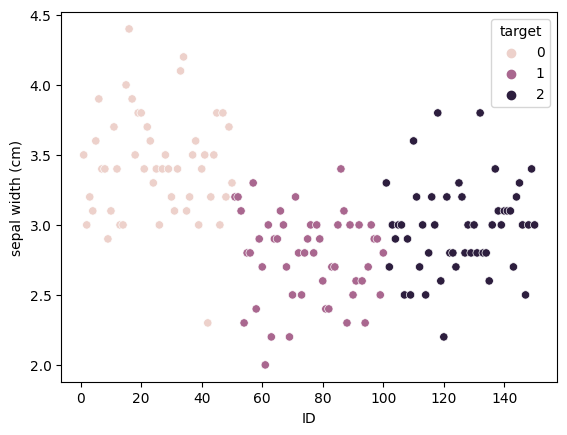

In [28]:
import seaborn as sns
sns.scatterplot(data=df, x="ID",y="sepal width (cm)",hue="target")

Lets keep the vmin to 2 cm and vmax as 4.2 cm and see the results after clipping.

<Axes: xlabel='ID', ylabel='sepal width new'>

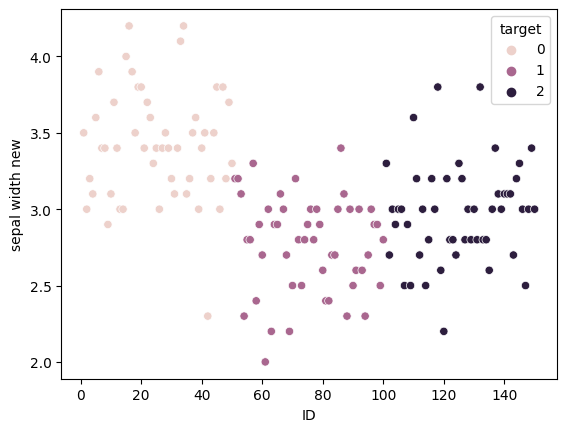

In [29]:
vmax = 4.2
vmin = 2
df['sepal width new'] = df['sepal width (cm)'].apply(lambda x: vmax if x > vmax else vmin if x < vmin else x)
sns.scatterplot(data=df, x="ID",y="sepal width new",hue="target")

### Task
Different metrics respond differently to the different feature normalizations. Try to apply one of the feature normalization and see how the distance metrics change. 

# Data Visualization



<!-- In this lab you will learn how to visualize a dataset and the various tools that can you help you do this. -->

It is often said **Data is only as good as it is presented**. Countless studies show how our brain is wired for the visual, and processes everything faster when it is through the eye. Therefore it becomes increasingly important to be able to APPRECIATE, INTERPRET and VISUALIZE data even before we start writing any form of code to process it.


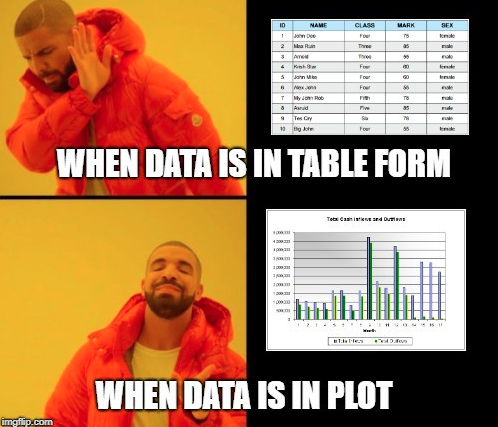

In this lab, you will learn simple ways to visualize your data using commonly-used libraries. Understanding the plots would further help in decoding the various features in the dataset and their impact on the target variables.

Data visualizations in Python can be done via many packages. We’ll be discussing first the *matplotlib* package which can be used in Python scripts, Jupyter notebook, and web application servers. 

### **Matplotlib**

It is a 2-D plotting library that helps in visualizing figures. Matplotlib emulates Matlab like graphs and visualizations. Matlab is not free, is difficult to scale and as a programming language is tedious. So, matplotlib in Python is used as it is a robust, free and easy library for data visualization.

#### **Anatomy of a Matplotlib Figure**

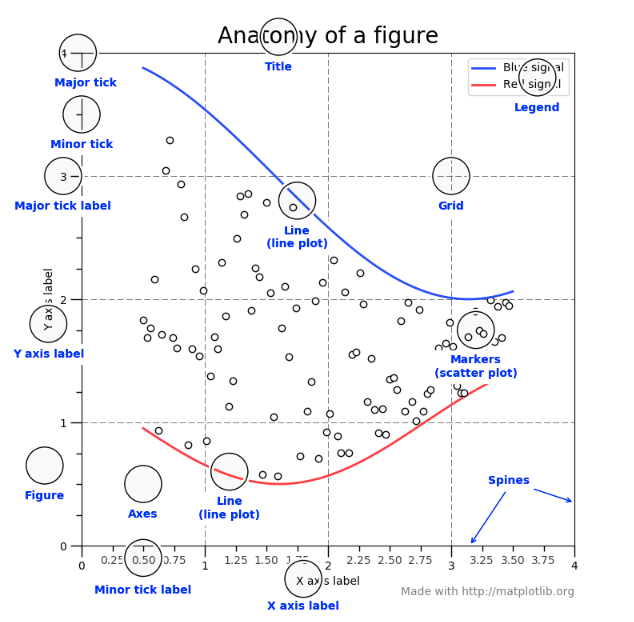

Let's start with a real dataset, the Automobile dataset from Kaggle (https://www.kaggle.com/toramky/automobile-dataset).

This dataset consists of data from 1985 Ward's Automotive Yearbook for some features relating to nearly 200 cars (e.g. the car maker, mileage, dimensions, etc.) and their prices.

In [30]:
import os
os.system("wget https://raw.githubusercontent.com/SP9144/FMML_Data/main/Automobile_data.csv")

0

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [32]:
# Loading the dataset

data = pd.read_csv("Automobile_data.csv")
print("Number of data points =", len(data))
data.head()

Number of data points = 205


,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.4,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.4,8.0,115,5500,18,22,17450


In [33]:
# Removing rows which have missing values

data.replace("?", np.nan, inplace = True)
data = data.dropna()
print(len(data))

159


In [34]:
# Dividing the dataset into features (X) and the target variable (y)

X = data.drop("price", axis = 1)
y = pd.to_numeric(data["price"])

To begin with let's see the plot for Car making company on the X-axis and the price of the car on the Y-axis.

To do this, we use matplotlib.pyplot's scatter() function to create a Scatter Plot for the same.

As far as Machine learning/Data Science is concerned, one of the most commonly used plot for simple data visualization is scatter plots. This plot gives us a representation of where each points in the entire dataset are present with respect to any 2/3 features (columns). Scatter plots are available in 2-D as well as 3D . The 2-D scatter plot is the important/common one, where we will primarily find patterns/clusters and separability of the data. The code snippet for using a scatter plot is as shown below.

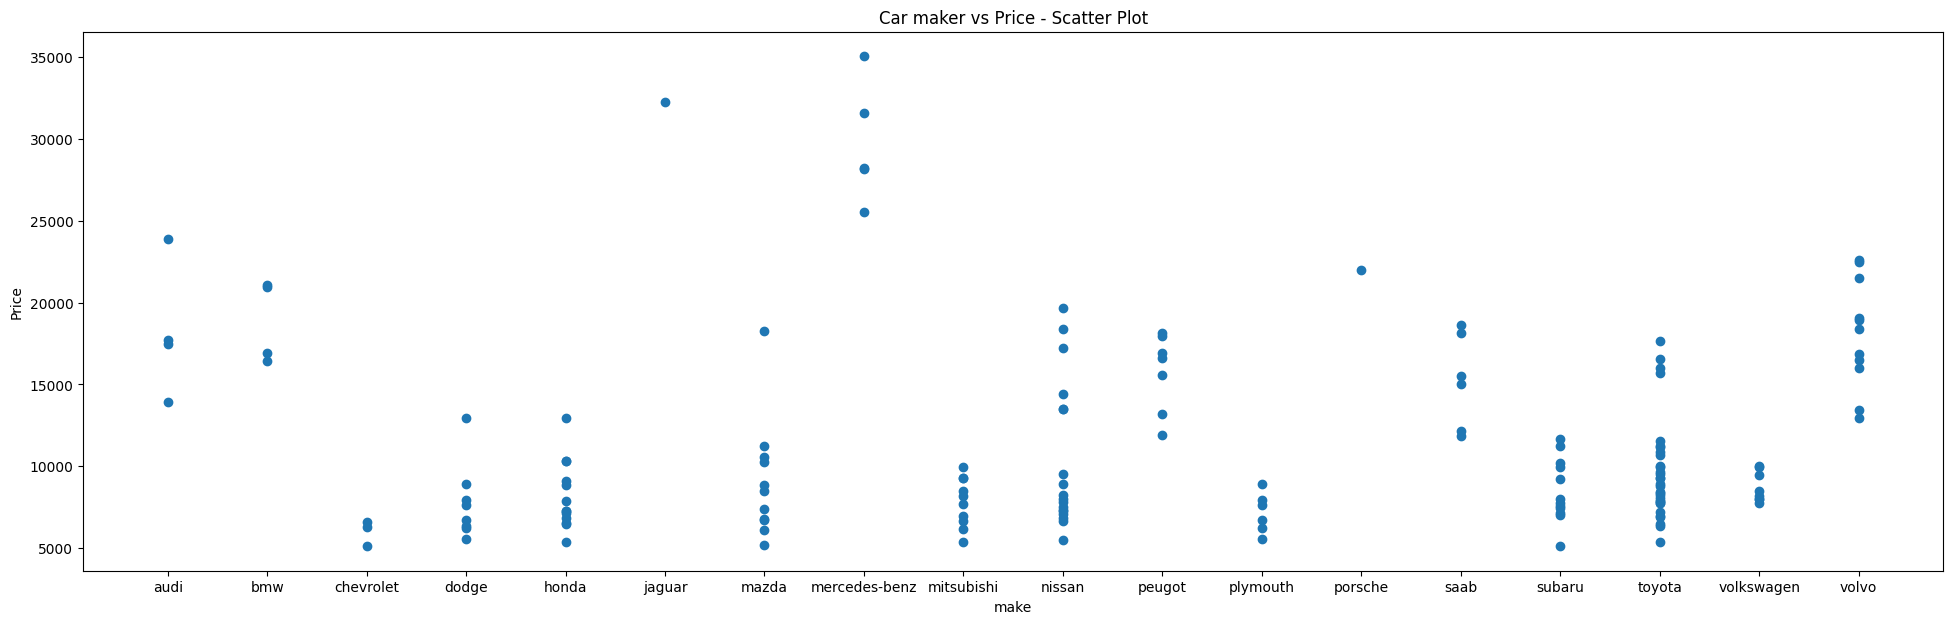

In [35]:
plt.figure(figsize = (24, 7))
plt.scatter(X["make"], y)
plt.xlabel('make')
plt.ylabel('Price')
plt.title('Car maker vs Price - Scatter Plot')
plt.show()

Even though the scatter plot clearly shows that some car makers like Mercedes-benz, Jaguar, Porsche and BMW keep their cars on the higher side of the price range. But is there a better way to understand the distribution of cars within these companies as well?

To do this, we will use the Seaborn package. Seaborn is a Python data visualization library based on matplotlib. 

We will be creating a Box Plot. This is the type of plot that can be used to obtain more of the statistical details about the data. The straight lines at the maximum and minimum are also called as whiskers. Points outside of whiskers will be inferred as an outliers. The box plot gives us a representation of 25th, 50th ,75th quartiles. From a box plot we can also see the Interquartile range(IQR) where maximum details of the data will be present. It also gives us a clear overview of outlier points in the data.

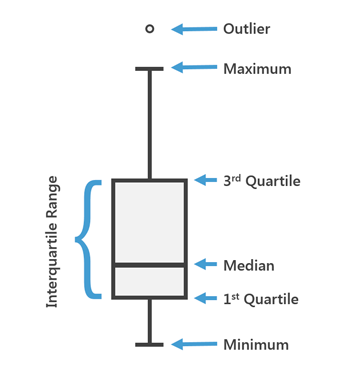

Text(0.5, 1.0, 'Car Manufacturer vs Price - Box Plot')

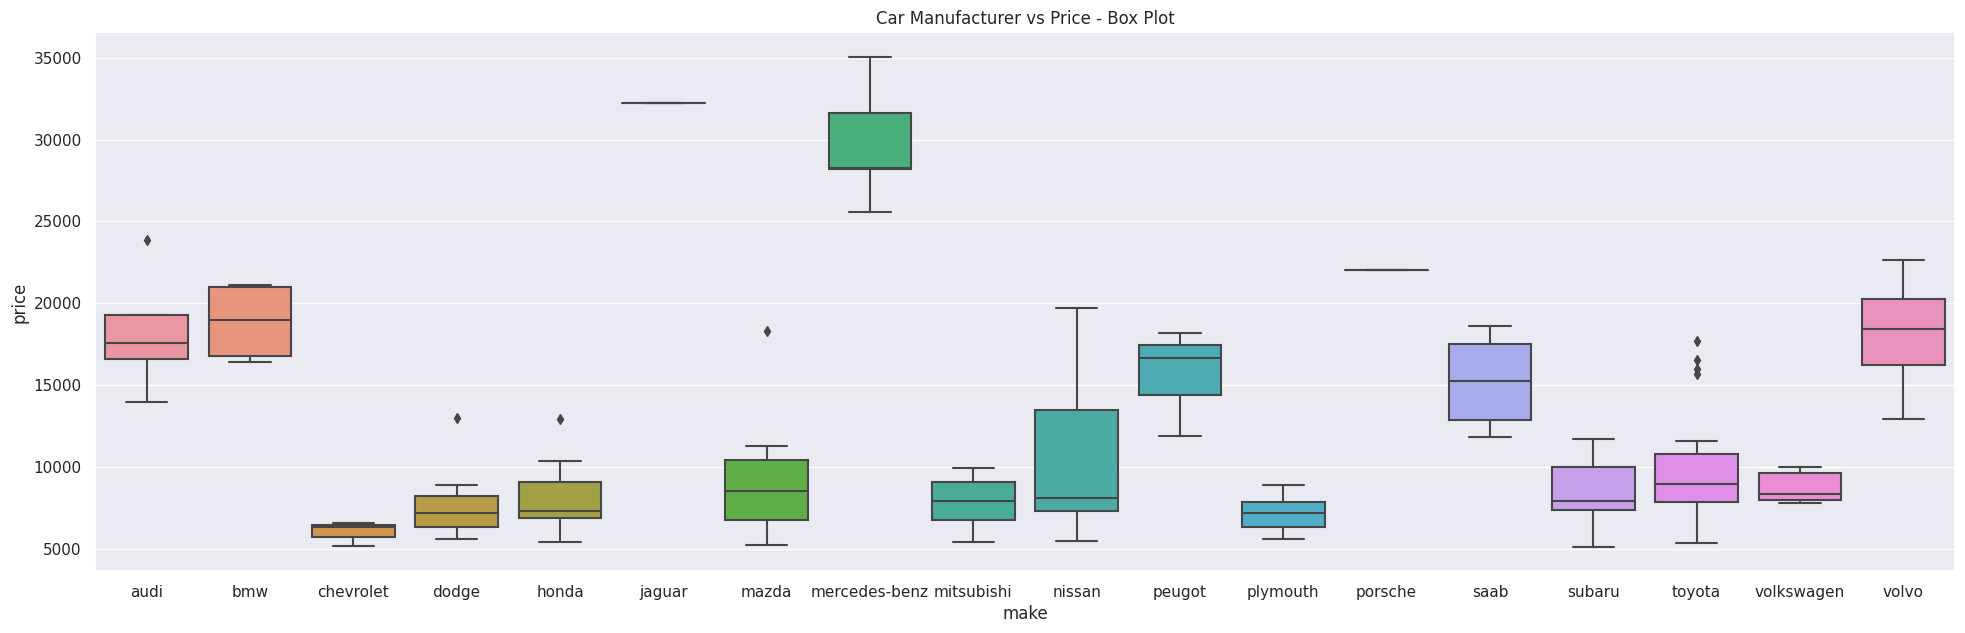

In [36]:
import seaborn as sns

sns.set(rc={'figure.figsize':(24,7)})
sns.boxplot(x=X["make"],y=y).set_title('Car Manufacturer vs Price - Box Plot')

It becomes evidently clear that Mercedes-Benz, Jaguar and Porsche have the costliest cars. BMW too has costly cars but the large interquartile range suggests that the company has a broader range of cars in the market. The outliers are also important as for example, Mazda has a car listed much higher than its normal price range.

All of these conclusions could be very hard to get to using the data in a tabular format, whereas it became evidently clear straight away once we used Visualization techniques to understand the dataset. 

You can also use a Violin Plot to understand the distribution within each car maker in a better way. These violin plots can be inferred as a combination of Box plot at the middle and distribution plots (Kernel Density Estimation) on both side of the data. This can give us the details of distribution like whether the distribution is mutimodal, its skewness etc. It also give us useful information like the 95% confidence interval. The below image can help us grasp some important parts from a violin plot.


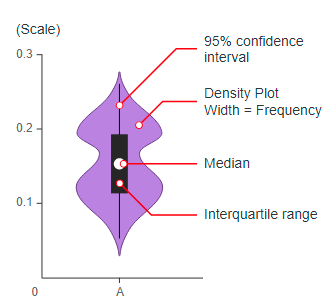

Text(0.5, 1.0, 'Car maker vs Price - Violin Plot')

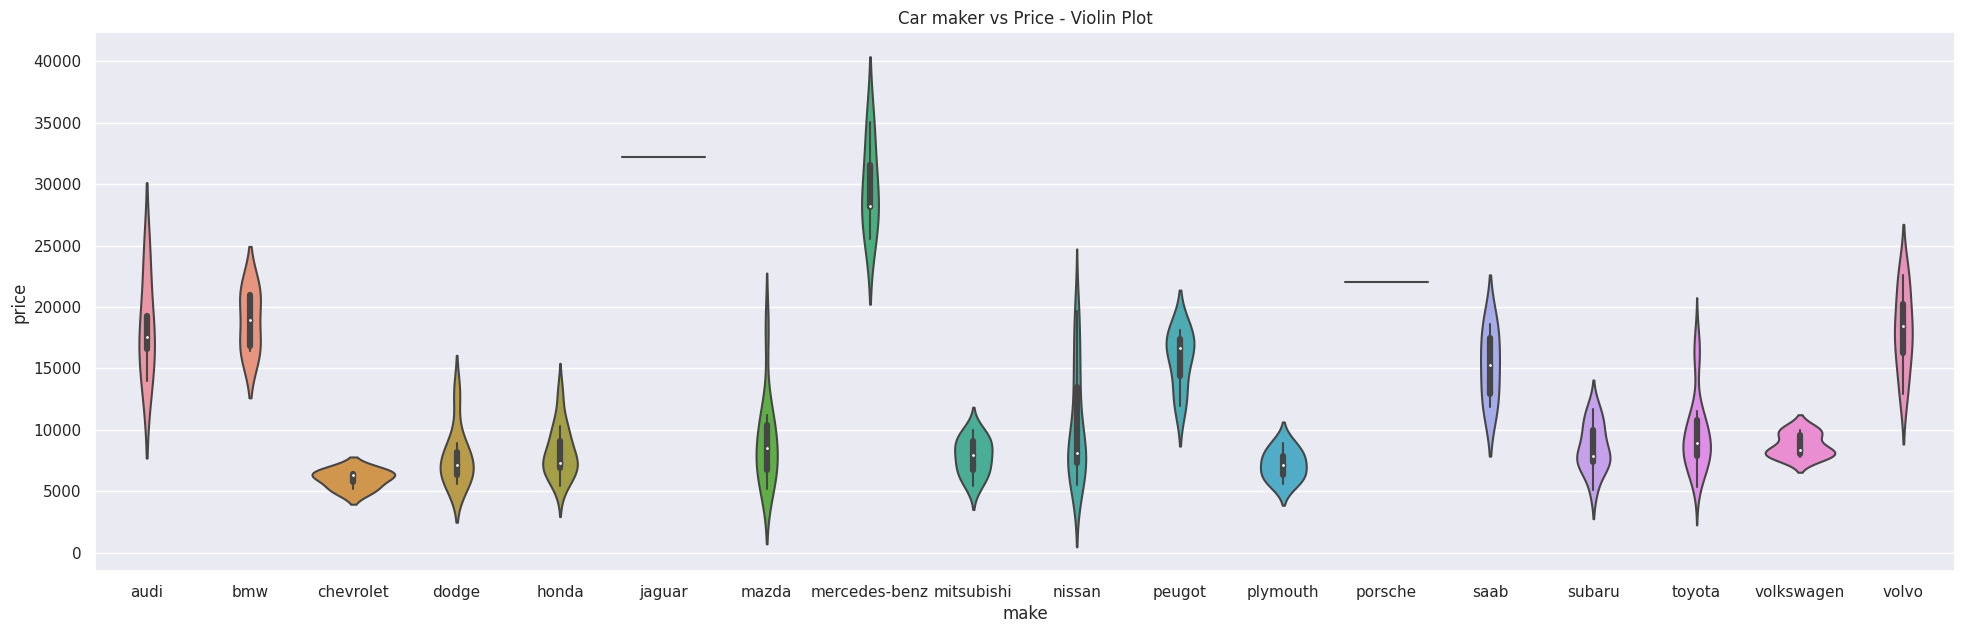

In [37]:
sns.violinplot(x=X["make"],y=y).set_title('Car maker vs Price - Violin Plot')

Another plot type are the Swarm Plots. They offer an alternate way of plotting the distribution of an attribute or the joint distribution of a couple of attributes. Unlike strip plots, swarm plots attempt to avoid obscuring points by calculating non-overlapping positions instead of adding random jitter. This sort of gives them appearance of a swarm of bees, or perhaps a honeycomb.

Text(0.5, 1.0, 'Car maker vs Price Swarm Plot')

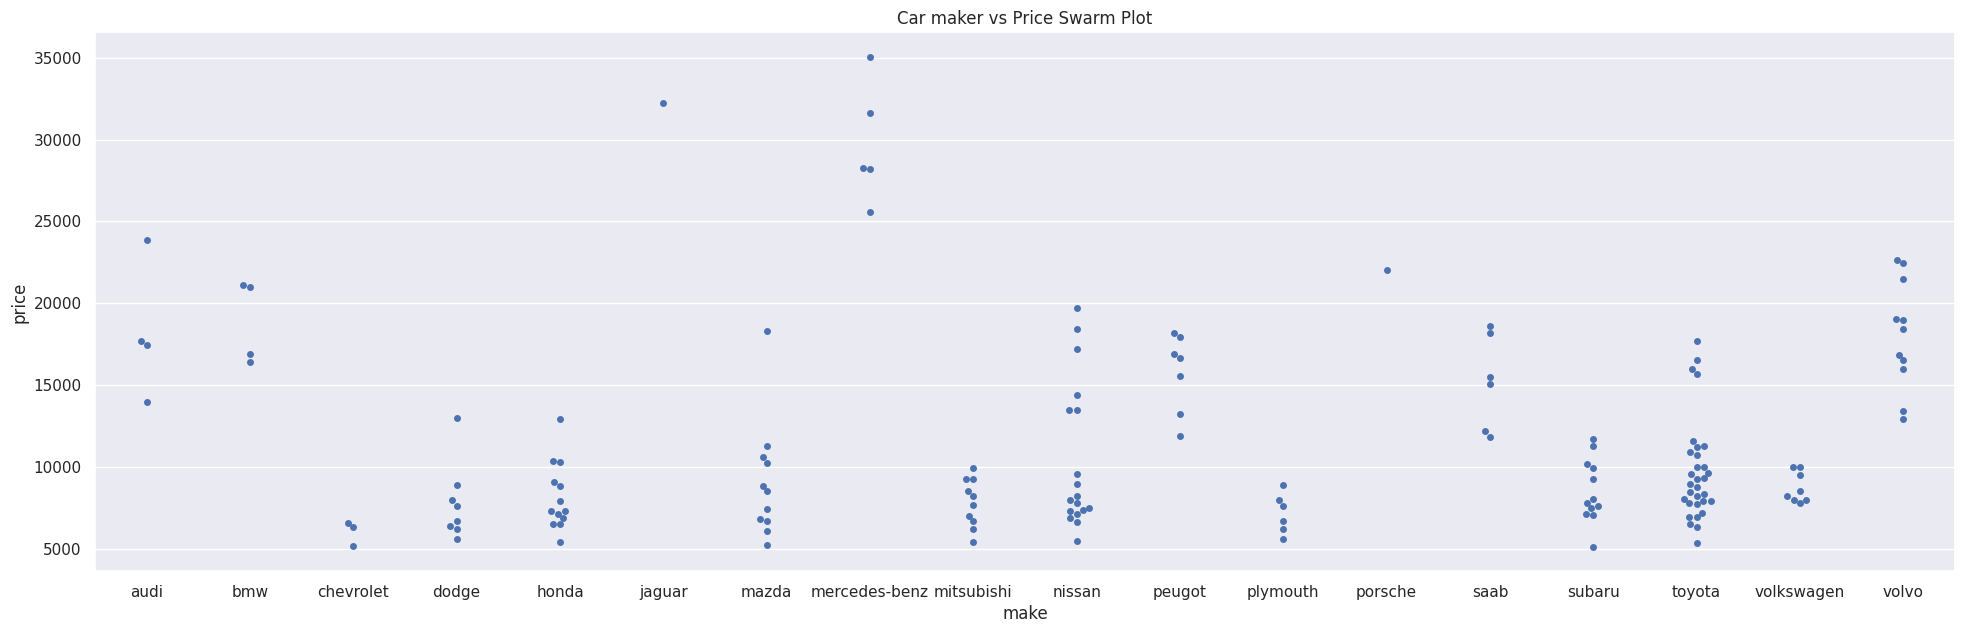

In [38]:
sns.swarmplot(x=X["make"],y=y).set_title('Car maker vs Price Swarm Plot')

Now let us try to learn a bit more about the various features in our dataset. One of the features is Horsepower, used to describe the power that an engine is capable of producing. A sensible assumption could be that Sport car companies like Porsche would have more cars with higher horsepowers. Lets check if this is actually true ...

Text(0.5, 1.0, 'Car maker vs Horsepower Box Plot')

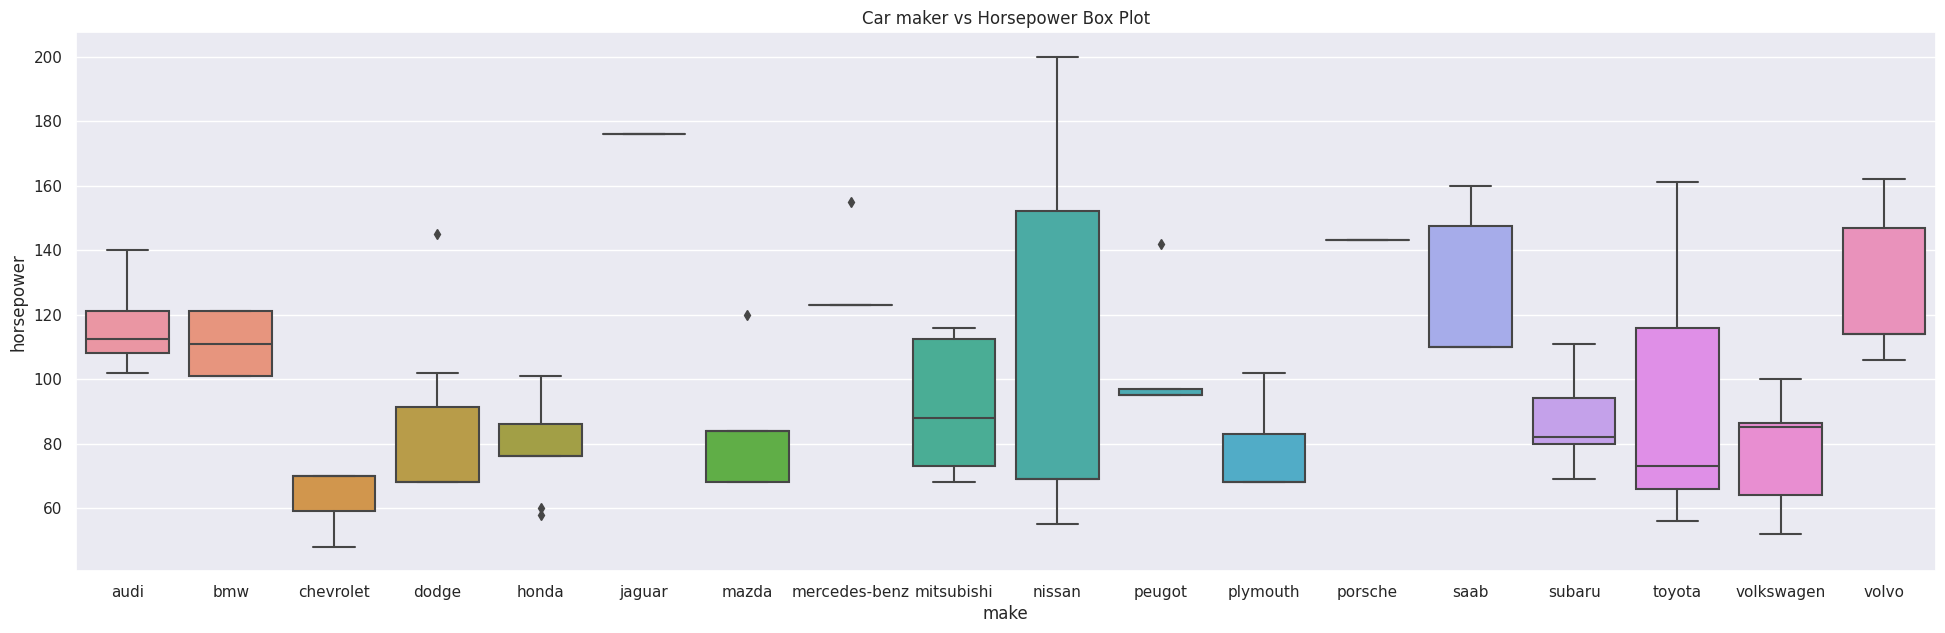

In [39]:
sns.boxplot(x=X["make"],y=pd.to_numeric(X["horsepower"])).set_title('Car maker vs Horsepower Box Plot')

As expected carmakers like Jaguar and Porsche have most of their cars with very high HP. A reasonable next step would be to see, if this new interesting feature has some correlation with our target variable "price". 

A simple way to check this is to again plot a scatterplot (but this time lets do this using Seaborn instead of Matplotlib).

An expected positive correlation should show up with most of the points lying around a line with a positive slope.

<Axes: xlabel='horsepower', ylabel='price'>

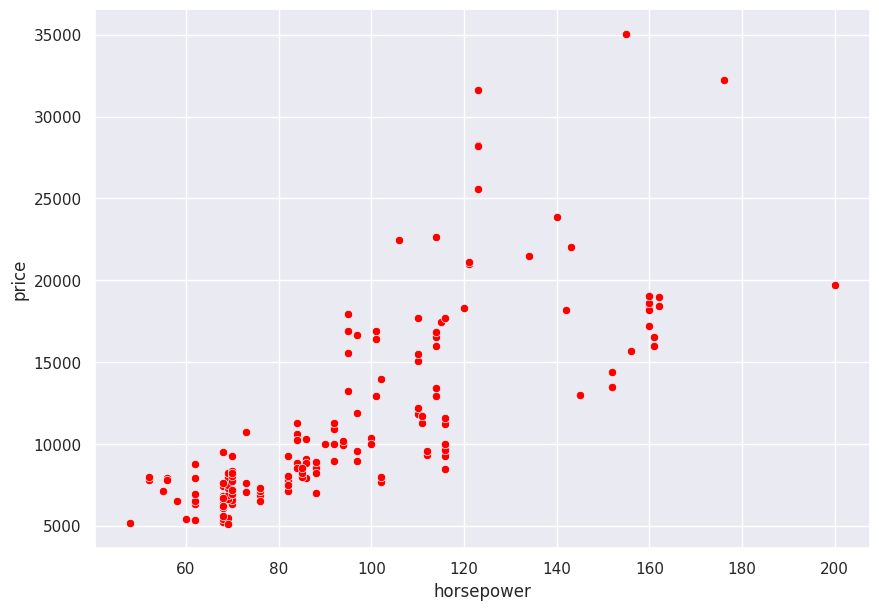

In [40]:
sns.set(rc={'figure.figsize':(10,7)})
sns.scatterplot(x=pd.to_numeric(X["horsepower"]), y = y, color = "red")

A better way of plotting these correlations is using a Jointplot instead of a simple scatter plot. The jointplot displays a relationship between 2 variables (bivariate) as well as 1D profiles (univariate) in the margins.

I have also used the parameter "reg" which fits a regression line through the points making the correlation sign apparent. A line with positive slope would indicate a postiive correlation and vice versa. A line parallel to x-axis would indicate no correlation between the 2 variables (implying independence).

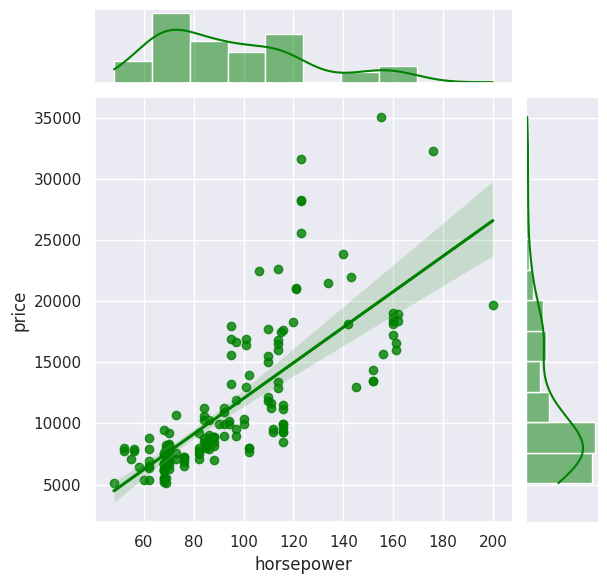

In [41]:
sns.jointplot(x=pd.to_numeric(X["horsepower"]), y = y, kind="reg", color = 'green')

## Exercise: Plot the jointplot for a feature which has negative correlation with the target variable "price". 

An example is shown below, with "highway-mpg" where MPG is miles per gallon.

### Hint: You should be using numeric features. The numeric features in the data are listed below: 

'symboling', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg'

#### You are motivated to try all of these features to better understand the dataset

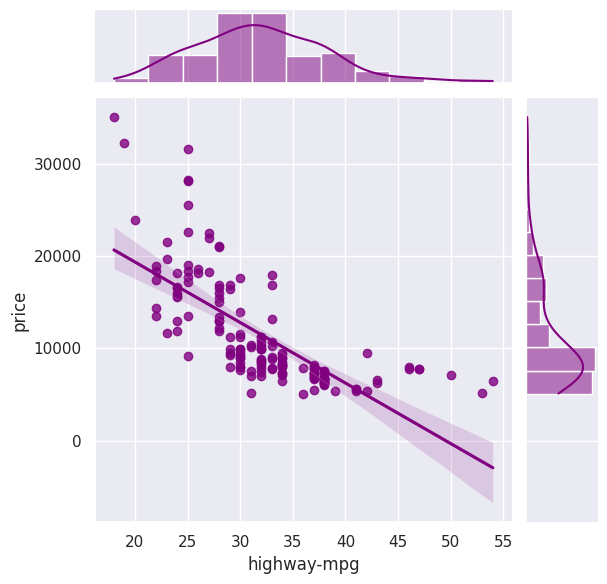

In [42]:
############################
### CHANGE THE CODE HERE ###

feature = "highway-mpg"

############################


sns.jointplot(x=pd.to_numeric(X[feature]), y = y, kind="reg", color = 'purple')

In [43]:
num_features = ['symboling', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg']

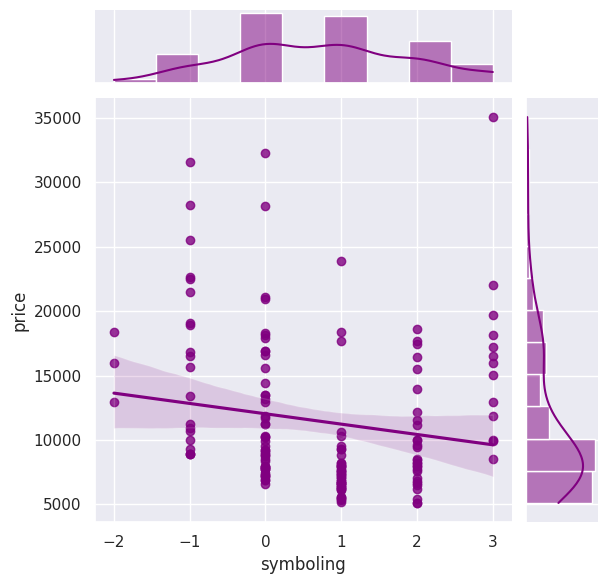

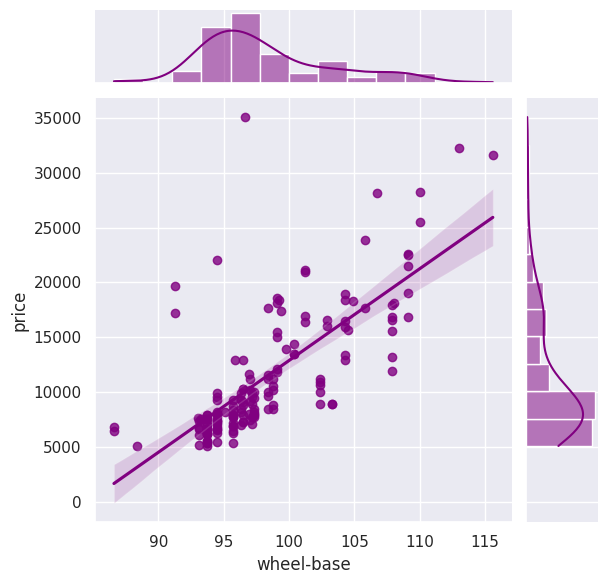

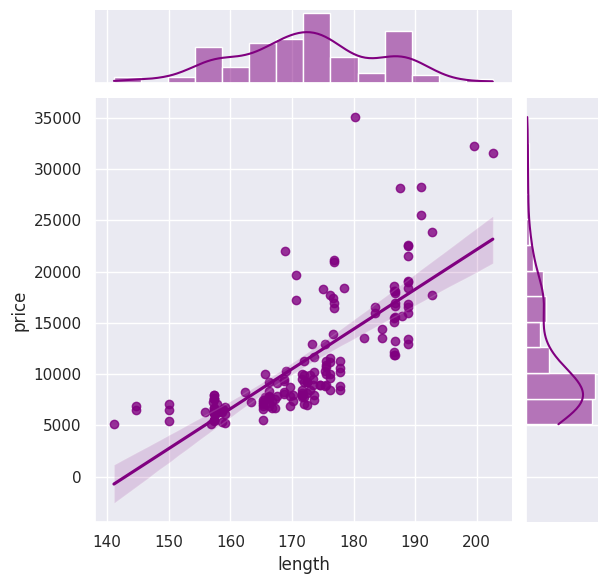

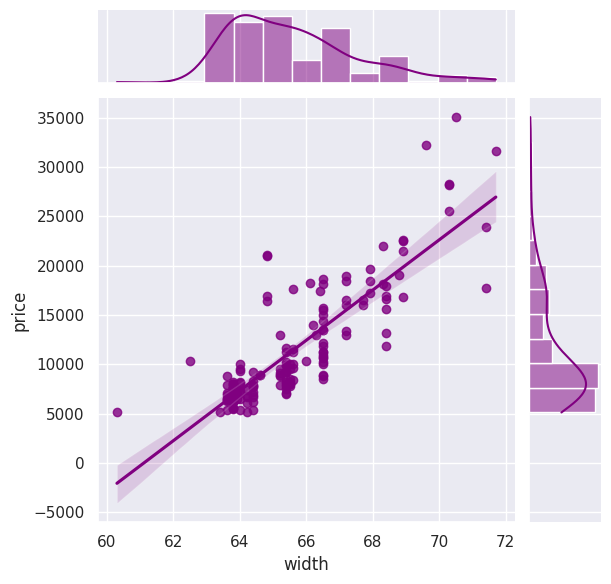

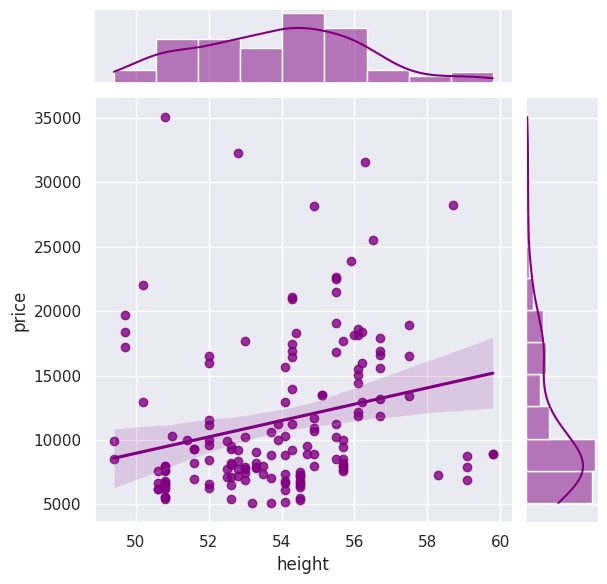

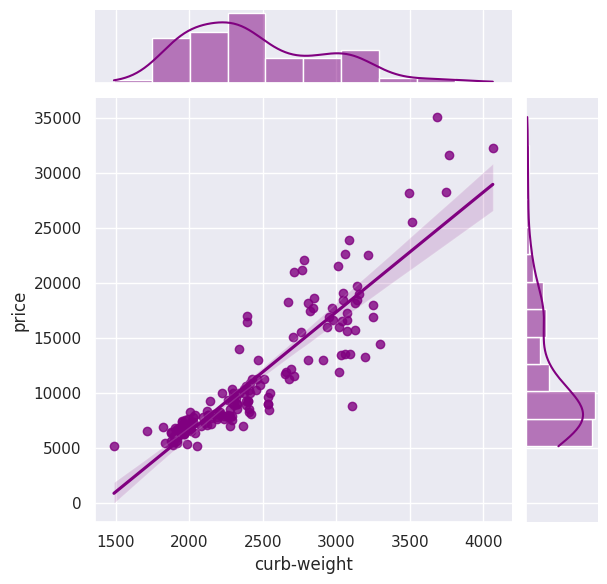

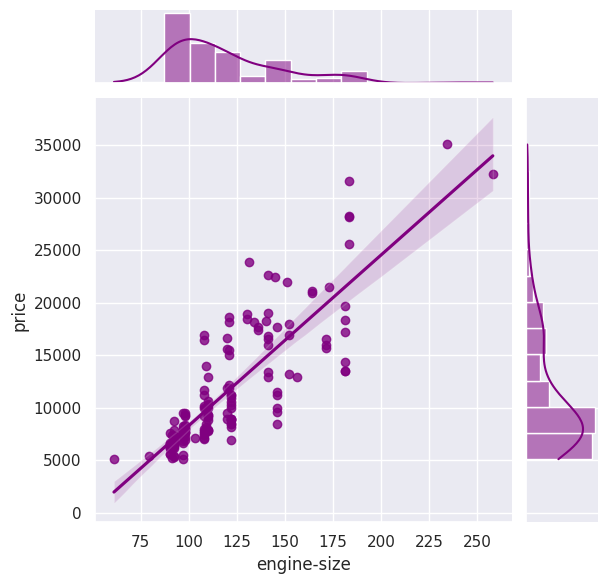

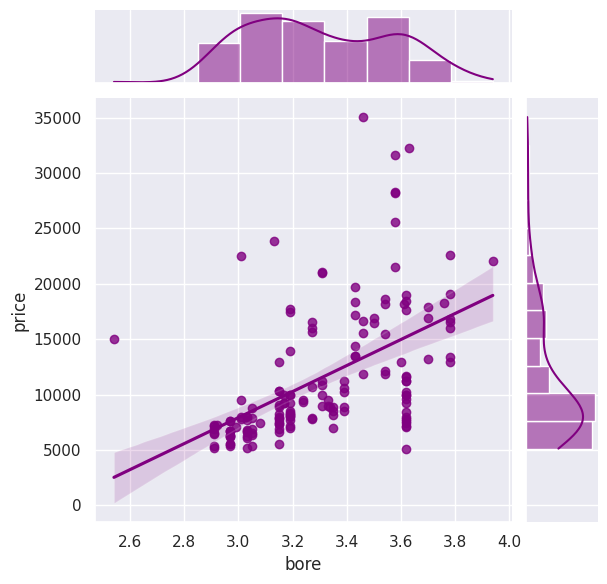

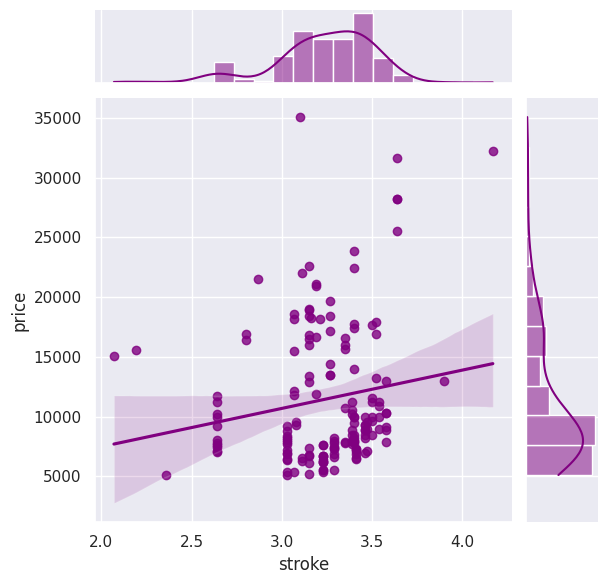

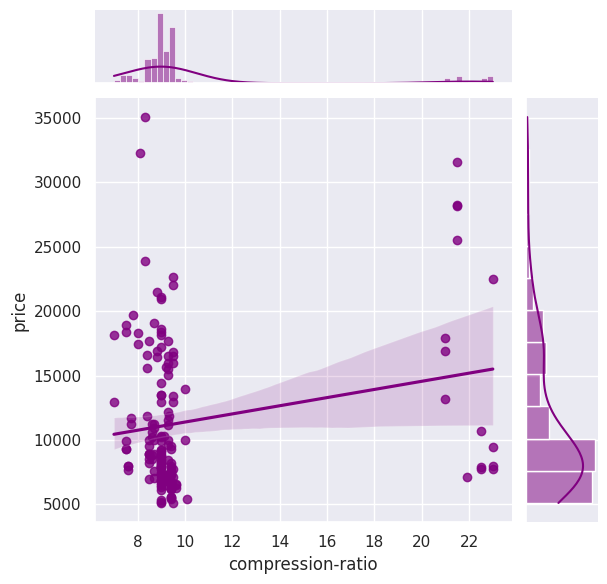

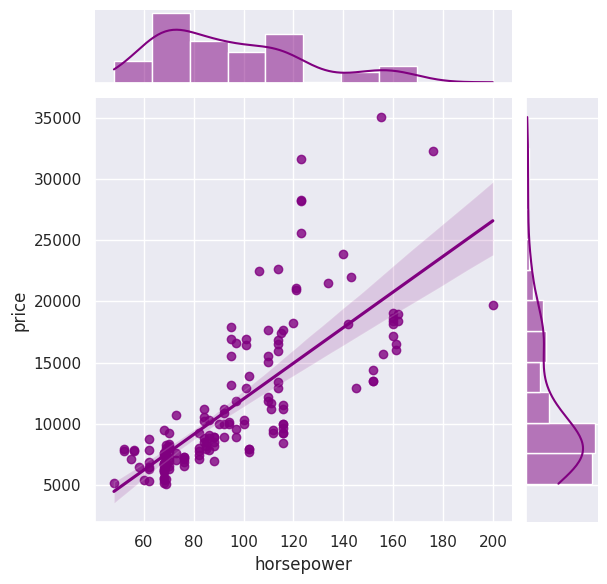

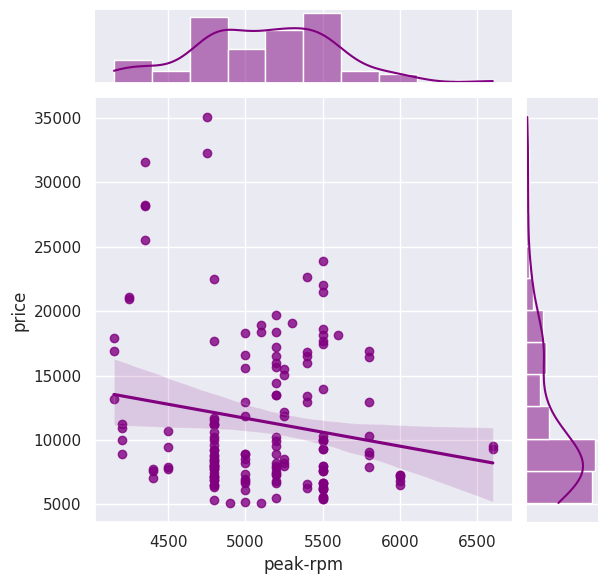

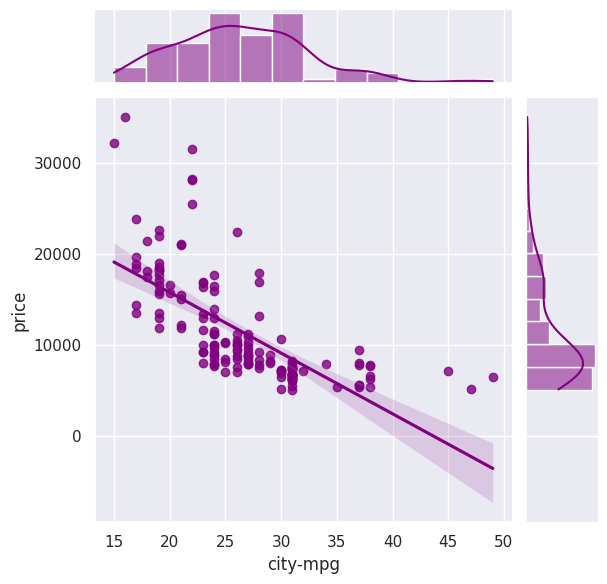

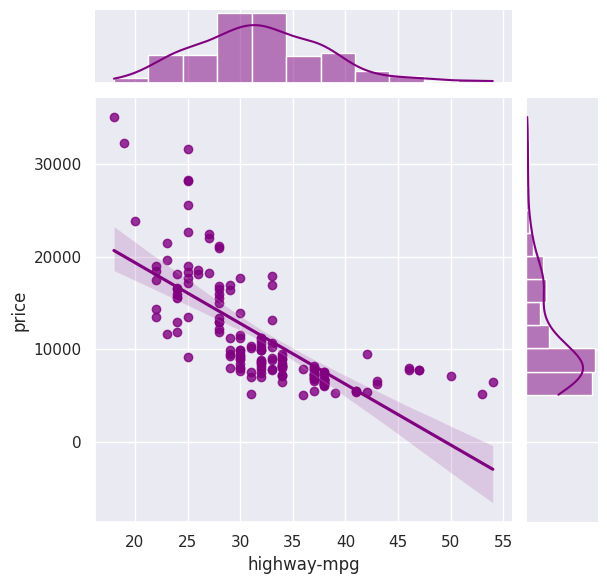

In [44]:
for i in num_features:
    sns.jointplot(x=pd.to_numeric(X[i]), y = y, kind="reg", color = 'purple')

## Question: Interpret the plot below. List all the interpretations point by point using the plot below.

Some pointers: 

1) Think about the maximum/minimum values for each body-type, which body-type is the "costliest" ?

2) Do you think maximum/minimum values are a clear indication of which body-type is costliest, or does the interpretation improve by also taking the interquartile range into consideration?

3) Do you think the body-style of a car can be a good predictor for its price? 


**Ans 1:** Convertible is the costliest.

**Ans 2:** The interpretation improves by also taking the interquartile range into consideration.

**Ans 3:** Including the body-style of a car as a predictor can be valuable in combination with other features, as it can help account for outliers and improve predictive accuracy.

Text(0.5, 1.0, 'Body style vs Price Box Plot')

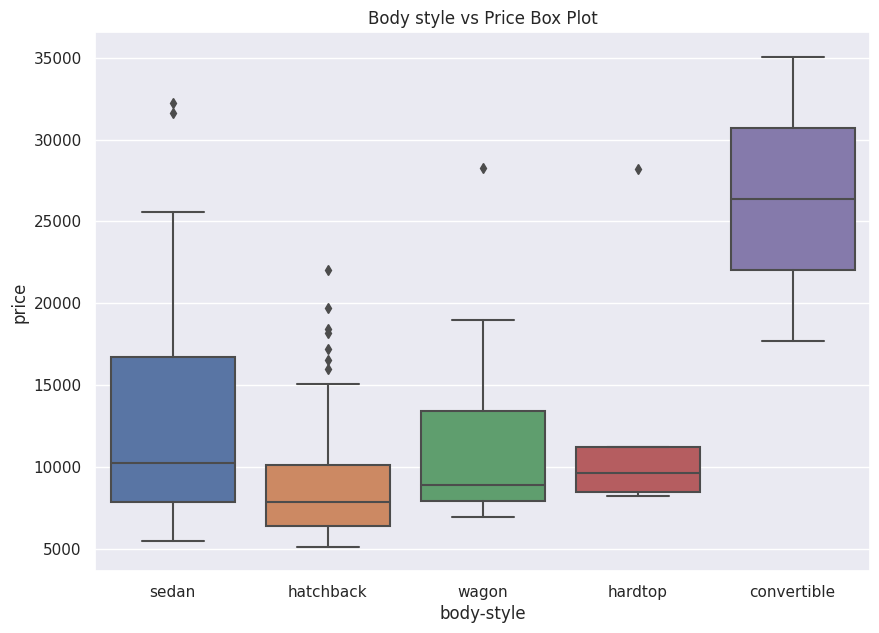

In [45]:
sns.boxplot(x=X["body-style"],y=y).set_title('Body style vs Price Box Plot')

Some interesting references:


1) https://towardsdatascience.com/data-visualization-using-matplotlib-16f1aae5ce70

2) https://towardsdatascience.com/data-visualization-for-machine-learning-and-data-science-a45178970be7


3) https://towardsdatascience.com/matplotlib-seaborn-basics-2bd7b66dbee2








# Dimensionality Reduction


![ater](https://storage.googleapis.com/lds-media/images/Dimensionality-Reduction-algorithms.width-1200.jpg)

**Feature Selection and Feature Extraction**

The code provided below demonstrates dimensionality reduction techniques using feature selection and feature extraction. The iris dataset from the seaborn library is used as an example dataset. Feature selection is performed using the SelectKBest algorithm with f_classif scoring, and feature extraction is performed using Principal Component Analysis (PCA).

In [46]:
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

# Load the iris dataset from seaborn
iris = sns.load_dataset("iris")

# Perform feature selection using SelectKBest and f_classif
X = iris.drop("species", axis=1)
y = iris["species"]

# Encode the categorical target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Select top two features using f_classif
selector = SelectKBest(f_classif, k=2)
X_selected = selector.fit_transform(X, y_encoded)

print("Selected features:")
print(X.columns[selector.get_support()])

# Perform feature extraction using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

print("\nPrincipal Components:")
print(X_pca)


Selected features:
Index(['petal_length', 'petal_width'], dtype='object')

Principal Components:
[[-2.68412563  0.31939725]
 [-2.71414169 -0.17700123]
 [-2.88899057 -0.14494943]
 [-2.74534286 -0.31829898]
 [-2.72871654  0.32675451]
 [-2.28085963  0.74133045]
 [-2.82053775 -0.08946138]
 [-2.62614497  0.16338496]
 [-2.88638273 -0.57831175]
 [-2.6727558  -0.11377425]
 [-2.50694709  0.6450689 ]
 [-2.61275523  0.01472994]
 [-2.78610927 -0.235112  ]
 [-3.22380374 -0.51139459]
 [-2.64475039  1.17876464]
 [-2.38603903  1.33806233]
 [-2.62352788  0.81067951]
 [-2.64829671  0.31184914]
 [-2.19982032  0.87283904]
 [-2.5879864   0.51356031]
 [-2.31025622  0.39134594]
 [-2.54370523  0.43299606]
 [-3.21593942  0.13346807]
 [-2.30273318  0.09870885]
 [-2.35575405 -0.03728186]
 [-2.50666891 -0.14601688]
 [-2.46882007  0.13095149]
 [-2.56231991  0.36771886]
 [-2.63953472  0.31203998]
 [-2.63198939 -0.19696122]
 [-2.58739848 -0.20431849]
 [-2.4099325   0.41092426]
 [-2.64886233  0.81336382]
 [-2.5987367

In summary, the code performs feature selection using the SelectKBest algorithm, identifying the most relevant features for classification. It then applies PCA to extract the two most significant components that capture the essence of the data. These steps help in reducing the dimensionality of the iris dataset and can be useful for various machine learning tasks.

Seaborn Documentation: https://seaborn.pydata.org/

Iris Dataset:

Seaborn Dataset Documentation: https://seaborn.pydata.org/generated/seaborn.load_dataset.html

UCI Machine Learning Repository (source of the iris dataset): https://archive.ics.uci.edu/ml/datasets/iris